# classification es el notebook oficial de clasificación

### - Limpiamos los datos según conclusiones del notebook main
### - Probaremos distintos algorítmos de clasificación y compararemos los resultados
### - Utilizamos el dataset de train ya recortado por la cátedra

---





## ACA TODOS LOS IMPORTS DEL NOTEBOOK

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, StratifiedShuffleSplit, validation_curve
from sklearn.feature_selection import RFECV
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score,accuracy_score,recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, auc, roc_auc_score, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, plot_precision_recall_curve, plot_roc_curve 

## LECTURA Y LIMPIEZA DEL DATASET

In [2]:
df_orig = pd.read_csv(r"DS_G3_HeartFailure_FULL_train.csv",index_col=0)

In [3]:
df_cleaned = df_orig.copy()
feat_train, targ_train = df_orig.drop(["DEATH_EVENT"],axis=1),df_orig["DEATH_EVENT"]

In [4]:
rfe = RFECV(RandomForestClassifier(n_estimators=2000),scoring="recall",min_features_to_select=5,cv=10,verbose=1,n_jobs=-1)
rfe = rfe.fit(feat_train,targ_train)

Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.


In [5]:
for feat in zip(feat_train.columns,rfe.support_):
    print(feat)

('age', True)
('anaemia', False)
('creatinine_phosphokinase', True)
('diabetes', False)
('ejection_fraction', True)
('high_blood_pressure', False)
('platelets', False)
('serum_creatinine', True)
('serum_sodium', False)
('sex', False)
('smoking', False)
('time', True)


## Transformaciones necesarias al df

In [4]:
df_orig.shape

(239, 13)

In [4]:
df_cleaned = df_orig.drop(["time","anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
#df_cleaned = df_orig.drop(["anaemia","diabetes","high_blood_pressure","sex","smoking"],axis=1)
# NOS QUEDAMOS CON AGE, EJECTION_FRACTION, SERUM_CREATININE, SERUM_SODIUM Y DEATH_EVENT
df_cleaned.head()

,age,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,DEATH_EVENT
55,95.0,371,30,461000.0,2.0,132,1
180,40.0,478,30,303000.0,0.9,136,0
237,70.0,232,30,173000.0,1.2,132,0
280,70.0,2695,40,241000.0,1.0,137,0
181,59.0,176,25,221000.0,1.0,136,1


In [41]:
#feat_train, feat_test, targ_train, targ_test = train_test_split(df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"],test_size=0.1,random_state=420)
#HAY QUE SEPARAR EL TEST ANTES DE ESTANDARIZAR PARA QUE NO INFLUYAN LOS FEATURES DE TEST EN LA MEDIA Y VARIANZA

In [5]:
feat_train, targ_train = df_cleaned.drop(["DEATH_EVENT"],axis=1),df_cleaned["DEATH_EVENT"]

In [6]:
scaler = StandardScaler()
feat_train = scaler.fit_transform(feat_train)
#APLICAMOS SMOTE PARA AUMENTAR LA CANTIDAD DE SAMPLES Y BALANCEAR EL TARGET
feat_train, targ_train = SMOTE().fit_resample(feat_train, targ_train)
feat_train.shape

(326, 6)

## ACA TENEMOS EL DATASET RECORTADO Y STANDARIZADO 

In [7]:
score_metric = "recall" # Queremos pocos FN, es decir pacientes q decimos q NO tienen riesgo pero SI.

---

## ALGUNAS FUNCIONES UTILES PARA GRAFICAR

In [8]:
def aoc_curves (model,feat,targ):
    predicted_p = cross_val_predict(model,feat,targ,cv=10,method="predict_proba")
    fpr, tpr, thres = roc_curve(targ, predicted_p[:,1])
    precisions, recalls, thres = precision_recall_curve(targ, predicted_p[:,1])
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recalls, precisions)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    plt.subplot(1,2,1)
    plt.plot(fpr,tpr,label = "ROC AOC:{:.3f}".format(roc_auc))
    plt.plot([0,1],[0,1],'--k', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(recalls,precisions,label = "PR AOC:{:.3f}".format(pr_auc))
    plt.plot([1,0],[0,1],'--k', alpha=0.5)
    plt.ylabel('Precisión')
    plt.xlabel('Recall')
    plt.title('Curva PR')
    plt.legend()

In [9]:
def train_test_curve (model,param,param_range): 
    train__scores, test__scores = validation_curve(model,feat_train,targ_train,param_name=param,param_range=param_range,scoring=score_metric,cv=20)

    train__mean = np.mean(train__scores,axis=1)
    #train__std = np.std(train__scores,axis=1)
    test__mean = np.mean(test__scores,axis=1)
    #test__std = np.std(test__scores,axis=1)
    plt.figure(figsize=(20,10))
    plt.subplot(2,2,2)
    plt.plot(param_range
                ,train__mean
                ,color='blue'
                ,marker='o'
                ,markersize=5
                ,label='training recall')
    plt.xscale("log")
    plt.plot(param_range
                ,test__mean
                ,color='green'
                ,marker='x'
                ,markersize=5
                ,label='test recall') 
    plt.xlabel(param)
    plt.ylabel(score_metric)
    plt.legend(loc='lower right')

---
---
---

# LOGISTIC REGRESSION - Baseline

## BEST PARAMS => C=0.2 -> Recall = 0.811+/-0.117

In [18]:
lr_model = LogisticRegression(fit_intercept=False, dual=False, max_iter=40000,C=0.2)
lr_model.fit(feat_train,targ_train)
lr_scoring = cross_val_score(lr_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(lr_scoring.mean(),lr_scoring.std()))
lr_predicted = cross_val_predict(lr_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, lr_predicted))

Cross Validation Score: 0.811 +/- 0.117
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       163
           1       0.72      0.81      0.76       163

    accuracy                           0.75       326
   macro avg       0.75      0.75      0.74       326
weighted avg       0.75      0.75      0.74       326



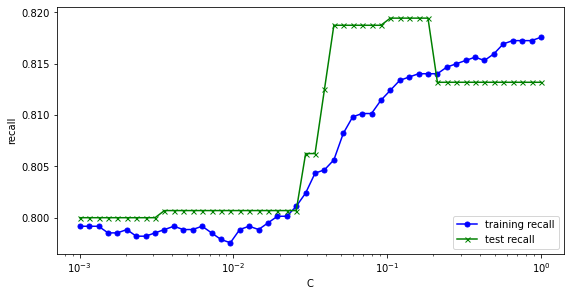

In [35]:
train_test_curve(lr_model,"C",np.logspace(-3,0,50))

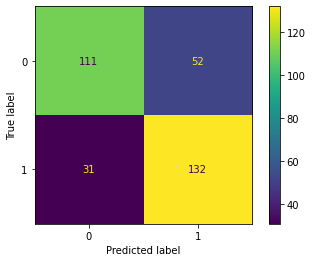

In [19]:
cm = confusion_matrix(targ_train, lr_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

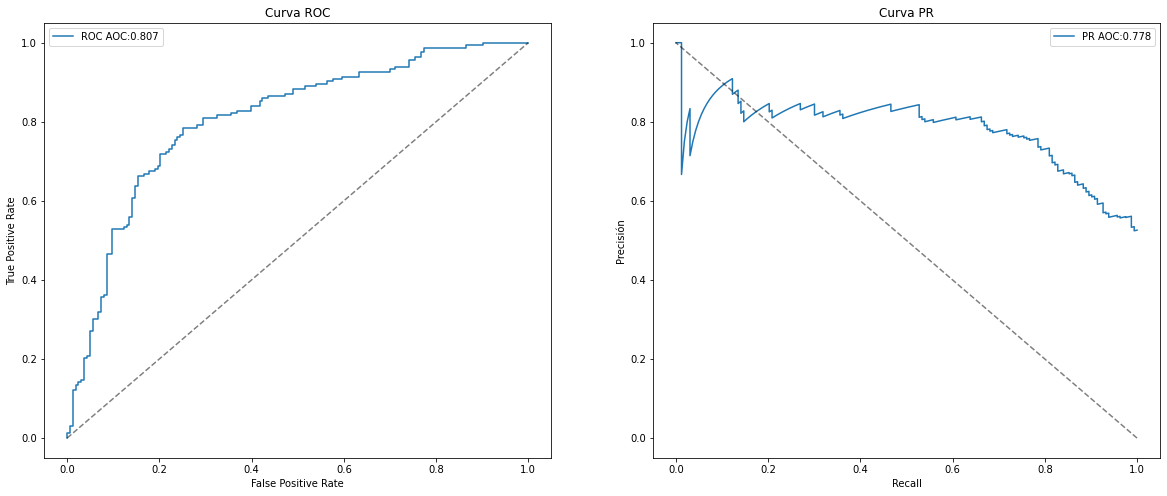

In [20]:
aoc_curves(lr_model,feat_train,targ_train)

---

# SVM

## BEST PARAMS => C = 0.85, Gamma = 0.61 -> Recall = 0.818+/-0.114

In [181]:
hyperparam = {"C":np.logspace(-2,0,30),"gamma":np.logspace(-2,0,20)}
svm_model = SVC(break_ties=True,probability=True)
svm_grilla = GridSearchCV(svm_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
svm_grilla.fit(feat_train,targ_train)
print(svm_grilla.best_params_)
svm_model = svm_grilla.best_estimator_

{'C': 0.6210169418915616, 'gamma': 0.7847599703514611}


In [27]:
svm_model = SVC(probability=True,gamma=0.61,C=0.85)
svm_model.fit(feat_train,targ_train)
svm_scoring = cross_val_score(svm_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(svm_scoring.mean(),svm_scoring.std()))
svm_predicted = cross_val_predict(svm_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, svm_predicted))


Cross Validation Score: 0.818 +/- 0.114
              precision    recall  f1-score   support

           0       0.80      0.75      0.78       163
           1       0.77      0.82      0.79       163

    accuracy                           0.79       326
   macro avg       0.79      0.79      0.79       326
weighted avg       0.79      0.79      0.79       326



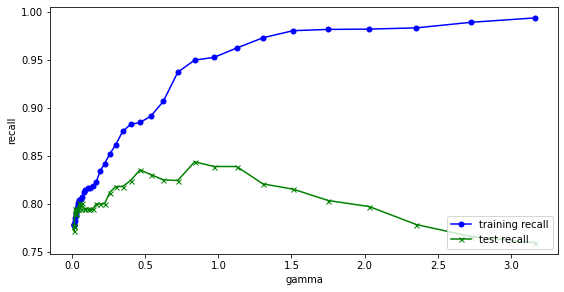

In [23]:
train_test_curve(svm_model,"gamma",np.logspace(-2,0.5,40))

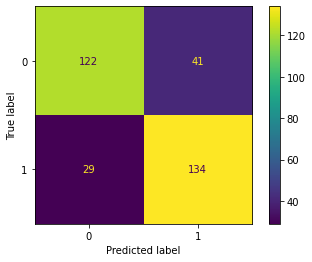

In [24]:
cm = confusion_matrix(targ_train, svm_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

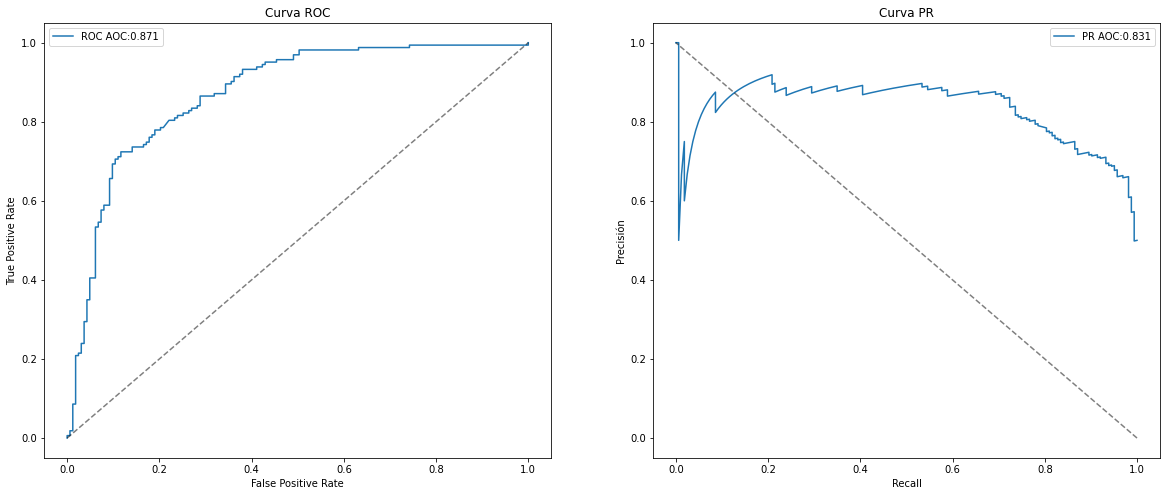

In [25]:
aoc_curves(svm_model,feat_train,targ_train)

---

# Random Forest

## BEST PARAMS => n_estimators = 400, min_impurity_decrease = 2e-4 -> Recall = 0.837+/-0.154

In [33]:
hyperparam = {"n_estimators":[40],"max_depth":[6],"min_samples_split":[40]}
rf_model = RandomForestClassifier()
rf_grilla = GridSearchCV(rf_model,hyperparam,cv=10,scoring=score_metric,n_jobs=-1)
rf_grilla.fit(feat_train,targ_train)
rf_model = rf_grilla.best_estimator_
print(rf_grilla.best_params_)

{'max_depth': 6, 'min_samples_split': 40, 'n_estimators': 40}


In [50]:
rf_model = RandomForestClassifier(n_estimators=400,min_impurity_decrease=2e-4)
rf_model.fit(feat_train,targ_train)
rf_scoring = cross_val_score(rf_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(rf_scoring.mean(),rf_scoring.std()))
rf_predicted = cross_val_predict(rf_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, rf_predicted))

Cross Validation Score: 0.837 +/- 0.154
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       163
           1       0.82      0.84      0.83       163

    accuracy                           0.83       326
   macro avg       0.83      0.83      0.83       326
weighted avg       0.83      0.83      0.83       326



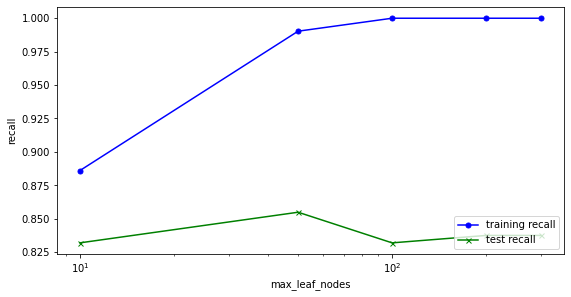

In [48]:
train_test_curve(rf_model,"max_leaf_nodes",[10,50,100,200,300])

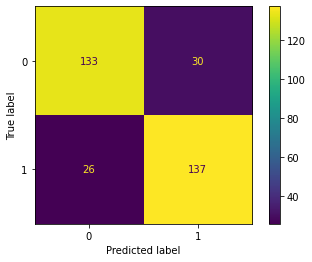

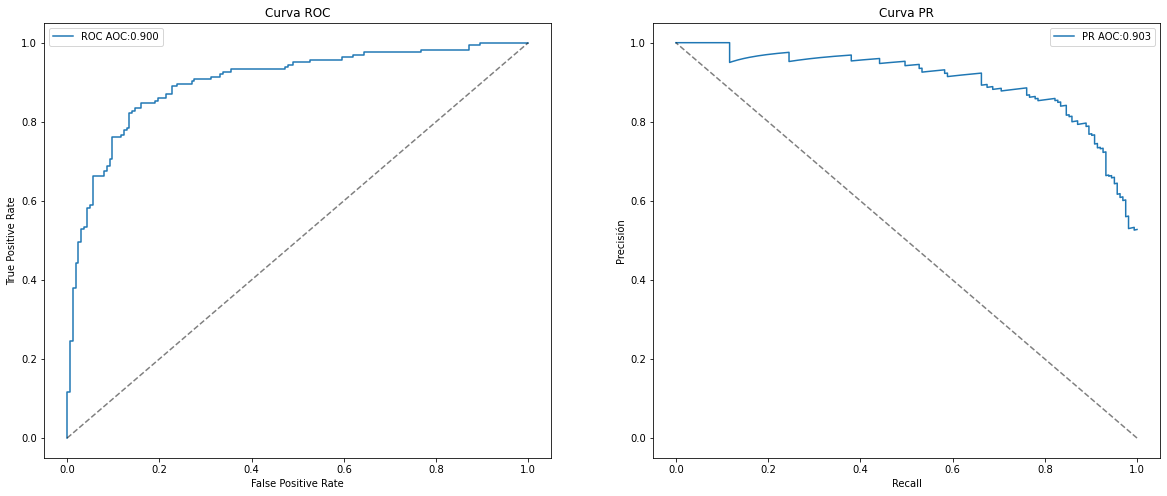

In [51]:
cm = confusion_matrix(targ_train, rf_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
aoc_curves(rf_model,feat_train,targ_train)


---


# GRADIENT BOOSTING

## BEST PARAMS => n_estimators = 500, learning_rate = 0.05,objective="binary:hinge" -> Recall = 0.843+/-0.158

### Cambia levemente la metodologia, usa early stopping

In [53]:
feat_train_2, feat_val, targ_train_2, targ_val = train_test_split(feat_train,targ_train,random_state=420)
# NECESARIO CREAR DATOS DE VALIDACION PARA USAR XGBC

In [ ]:
XGBClassifier?

In [138]:
xgbc_model = XGBClassifier(use_label_encoder=False,objective='binary:hinge',learning_rate=0.05,n_estimators=150)
xgbc_model.fit(feat_train_2,targ_train_2,eval_set=[(feat_train_2, targ_train_2), (feat_val, targ_val)],eval_metric='error',early_stopping_rounds=100,verbose=True)
xgbc_scoring = cross_val_score(xgbc_model, feat_train, targ_train,cv=10, scoring=score_metric)
print("Cross Validation Score: {:.3f} +/- {:.3f}".format(xgbc_scoring.mean(),xgbc_scoring.std())) 

[0]	validation_0-error:0.52459	validation_1-error:0.42683
[1]	validation_0-error:0.52459	validation_1-error:0.42683
[2]	validation_0-error:0.52459	validation_1-error:0.42683
[3]	validation_0-error:0.52459	validation_1-error:0.42683
[4]	validation_0-error:0.52459	validation_1-error:0.42683
[5]	validation_0-error:0.52459	validation_1-error:0.42683
[6]	validation_0-error:0.52459	validation_1-error:0.42683
[7]	validation_0-error:0.52459	validation_1-error:0.42683
[8]	validation_0-error:0.52459	validation_1-error:0.42683
[9]	validation_0-error:0.52459	validation_1-error:0.42683
[10]	validation_0-error:0.32377	validation_1-error:0.36585
[11]	validation_0-error:0.29098	validation_1-error:0.35366
[12]	validation_0-error:0.29098	validation_1-error:0.34146
[13]	validation_0-error:0.27049	validation_1-error:0.32927
[14]	validation_0-error:0.21721	validation_1-error:0.32927
[15]	validation_0-error:0.11066	validation_1-error:0.29268
[16]	validation_0-error:0.07377	validation_1-error:0.23171
[17]	va

              precision    recall  f1-score   support

           0       0.82      0.74      0.78       163
           1       0.77      0.84      0.80       163

    accuracy                           0.79       326
   macro avg       0.79      0.79      0.79       326
weighted avg       0.79      0.79      0.79       326



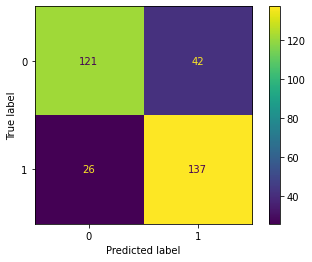

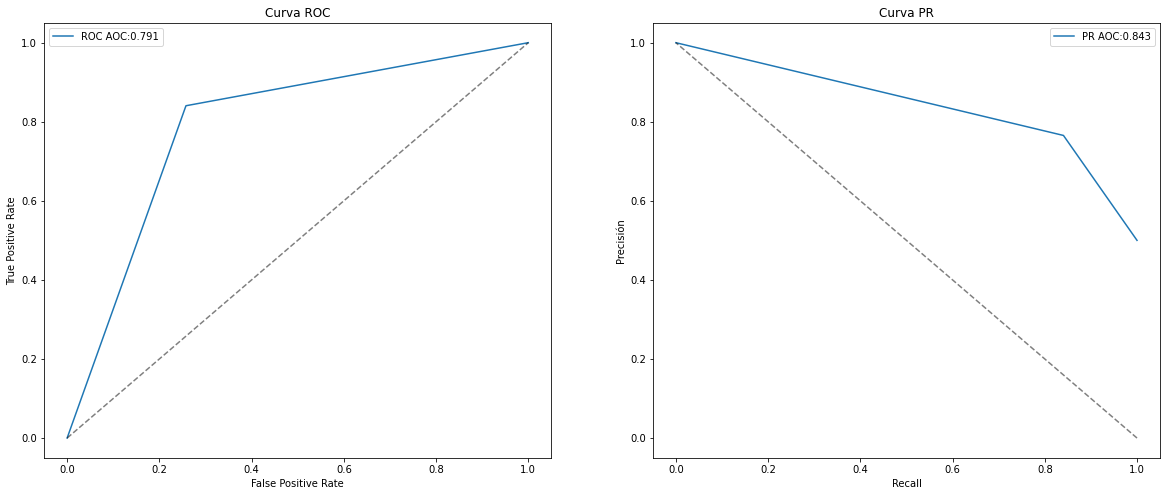

In [139]:
xgbc_predicted = cross_val_predict(xgbc_model,feat_train,targ_train,cv=10)
print(classification_report(targ_train, xgbc_predicted))
cm = confusion_matrix(targ_train, xgbc_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
aoc_curves(xgbc_model,feat_train,targ_train)